Make sure, on the same folder of the notebook, you have a folder containing the ff:

```
data
	augmented_data
		images
	cropped_data
		test
		train
		valid
	paper_imgs
```


In [1]:
import skimage as ski
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage import color, filters, data, img_as_float, exposure
from skimage.filters import difference_of_gaussians, window
from skimage.morphology import erosion, dilation, opening, closing, white_tophat  # noqa
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa
from scipy.fft import fftn, fftshift
from a2_external_utils import GridMask, get_random_eraser
import albumentations as A
import shutil

In [2]:
#  Comment out if need to install
# %pip install roboflow

from roboflow import Roboflow

api_key="" # TODO: ADD YOUR API KEY
rf = Roboflow(api_key=api_key)
project = rf.workspace("assignment2-1vhgw").project("assignment_2-mvtd6")
version = project.version(4)
dataset_splitted = version.download("tensorflow")

version = project.version(1)
dataset_alltrain = version.download("tensorflow")

alltrain = dataset_alltrain.name + "-" + dataset_alltrain.version
splitted = dataset_splitted.name + "-" + dataset_splitted.version

print(alltrain, splitted)

loading Roboflow workspace...
loading Roboflow project...
Assignment_2-1 Assignment_2-4


In [3]:
data_folder = alltrain + "/"

# Dataset Statistics


In [4]:
def describe_annotation_df(filepath=data_folder + "train/_annotations.csv", df=pd.DataFrame()):
    if len(df):
        annotation_df = df
    else:
        annotation_df = pd.read_csv(filepath)
    annotation_df["ymin_percentage"] = (
        annotation_df["ymin"] / annotation_df["height"]
    ) * 100
    annotation_df["ymax_percentage"] = 100 - (
        annotation_df["ymax"] / annotation_df["height"]
    ) * 100
    annotation_df["xmin_percentage"] = (
        annotation_df["xmin"] / annotation_df["width"]
    ) * 100
    annotation_df["xmax_percentage"] = (
        100 - (annotation_df["xmax"] / annotation_df["width"]) * 100
    )
    display(annotation_df.describe())
    print("Sample rows:")

    display(annotation_df.head())
    print("Class Distribution: long tailed")
    display(annotation_df["class"].value_counts())
    return annotation_df

### Describing Train, Validation and Test


In [5]:
annotation_train_df = describe_annotation_df(splitted + "/train/_annotations.csv")

,width,height,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
count,380.0,380.0,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1615.0,840.0,758.610526,452.273684,871.592105,583.594737,53.842105,30.524436,46.972788,46.031449
std,0.0,0.0,402.652270,46.135099,404.745673,44.908514,5.492274,5.346252,24.932029,25.061652
min,1615.0,840.0,187.000000,312.000000,324.000000,442.000000,37.142857,11.428571,11.578947,13.003096
25%,1615.0,840.0,359.000000,428.000000,469.000000,557.500000,50.952381,26.904762,22.229102,21.486068
50%,1615.0,840.0,1072.500000,457.500000,1173.000000,586.500000,54.464286,30.178571,66.408669,27.368421
75%,1615.0,840.0,1154.000000,482.500000,1268.000000,614.000000,57.440476,33.630952,71.455108,70.959752
max,1615.0,840.0,1325.000000,734.000000,1405.000000,744.000000,87.380952,47.380952,82.043344,79.938080


Sample rows:


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
0,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,319,502,445,636,59.761905,24.285714,19.752322,72.445820
1,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,1177,514,1297,634,61.190476,24.523810,72.879257,19.690402
2,202_JPG.rf.fb4e62cf8104d9c9b80af4c6c1bd8a03.jpg,1615,840,Erupted,1139,454,1248,594,54.047619,29.285714,70.526316,22.724458
3,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,390,426,515,539,50.714286,35.833333,24.148607,68.111455
4,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,1145,425,1270,524,50.595238,37.619048,70.897833,21.362229


Class Distribution: long tailed


class
Erupted          189
Mesio-angular    110
Horizontal        41
Vertical          37
Disto-angular      3
Name: count, dtype: int64

In [6]:
class_val = "Horizontal"
byclass_df = annotation_train_df[annotation_train_df["class"] == class_val]
byclass_files = list(byclass_df["filename"].unique())
has_class_df = annotation_train_df[annotation_train_df["filename"].isin(byclass_files)]
has_class_df["class"].value_counts()

class
Horizontal       41
Erupted           5
Vertical          3
Mesio-angular     2
Name: count, dtype: int64

In [7]:
annotation_valid_df = describe_annotation_df(splitted + "/valid/_annotations.csv")

,width,height,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
count,82.0,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,1615.0,840.0,725.951220,452.390244,836.719512,583.560976,53.855981,30.528455,44.950540,48.190742
std,0.0,0.0,412.406515,40.955187,413.166193,41.813253,4.875617,4.977768,25.536007,25.583046
min,1615.0,840.0,227.000000,310.000000,349.000000,466.000000,36.904762,20.000000,14.055728,14.055728
25%,1615.0,840.0,348.750000,432.000000,456.250000,562.250000,51.428571,27.619048,21.594427,21.934985
50%,1615.0,840.0,418.500000,452.000000,518.500000,587.500000,53.809524,30.059524,25.913313,67.894737
75%,1615.0,840.0,1156.250000,489.750000,1260.750000,608.000000,58.303571,33.065476,71.594427,71.749226
max,1615.0,840.0,1252.000000,545.000000,1388.000000,672.000000,64.880952,44.523810,77.523220,78.390093


Sample rows:


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
0,966_JPG.rf.01bec3d7fa4640e38d34b8547bc83012.jpg,1615,840,Erupted,389,489,463,612,58.214286,27.142857,24.086687,71.331269
1,966_JPG.rf.01bec3d7fa4640e38d34b8547bc83012.jpg,1615,840,Erupted,1179,495,1257,603,58.928571,28.214286,73.003096,22.167183
2,997_JPG.rf.0175e6ec66d9a1d7bae232e26e685955.jpg,1615,840,Erupted,410,402,505,536,47.857143,36.190476,25.386997,68.730650
3,997_JPG.rf.0175e6ec66d9a1d7bae232e26e685955.jpg,1615,840,Erupted,1104,417,1212,562,49.642857,33.095238,68.359133,24.953560
4,675_JPG.rf.0bd564ee1eabd708baf55e8e774a1438.jpg,1615,840,Horizontal,305,439,427,527,52.261905,37.261905,18.885449,73.560372


Class Distribution: long tailed


class
Erupted          55
Mesio-angular    20
Horizontal        3
Vertical          2
Disto-angular     2
Name: count, dtype: int64

In [8]:
annotation_test_df = describe_annotation_df(splitted + "/test/_annotations.csv")

,width,height,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
count,78.0,78.0,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,1615.0,840.0,746.423077,443.692308,859.756410,576.948718,52.820513,31.315629,46.218147,46.764309
std,0.0,0.0,410.243751,46.791415,413.672472,45.369449,5.570407,5.401125,25.402090,25.614395
min,1615.0,840.0,255.000000,322.000000,347.000000,455.000000,38.333333,19.523810,15.789474,14.489164
25%,1615.0,840.0,350.500000,414.250000,475.500000,546.500000,49.315476,27.648810,21.702786,20.990712
50%,1615.0,840.0,443.000000,448.500000,530.500000,580.000000,53.392857,30.952381,27.430341,67.151703
75%,1615.0,840.0,1157.250000,478.000000,1276.000000,607.750000,56.904762,34.940476,71.656347,70.557276
max,1615.0,840.0,1254.000000,531.000000,1381.000000,676.000000,63.214286,45.833333,77.647059,78.513932


Sample rows:


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
0,773_JPG.rf.4efbb4769df69cf6f4cc8f236e778f72.jpg,1615,840,Erupted,372,450,481,586,53.571429,30.238095,23.034056,70.216718
1,773_JPG.rf.4efbb4769df69cf6f4cc8f236e778f72.jpg,1615,840,Erupted,1140,434,1245,560,51.666667,33.333333,70.588235,22.910217
2,884_JPG.rf.318b04a90270d4c4cf17829273e743a7.jpg,1615,840,Erupted,375,372,491,531,44.285714,36.785714,23.219814,69.597523
3,884_JPG.rf.318b04a90270d4c4cf17829273e743a7.jpg,1615,840,Erupted,1142,374,1254,515,44.523810,38.690476,70.712074,22.352941
4,890_JPG.rf.06cc866d7ff157e3f9b1902d163898fe.jpg,1615,840,Erupted,395,472,480,618,56.190476,26.428571,24.458204,70.278638


Class Distribution: long tailed


class
Erupted          49
Mesio-angular    17
Vertical          6
Horizontal        5
Disto-angular     1
Name: count, dtype: int64

In [9]:
display(annotation_train_df[annotation_train_df["class"] == "Disto-angular"])
display(annotation_valid_df[annotation_valid_df["class"] == "Disto-angular"])
display(annotation_test_df[annotation_test_df["class"] == "Disto-angular"])

,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
17,174_JPG.rf.fdf4dc7ef7a90ebbbca3fafc1cd3ad24.jpg,1615,840,Disto-angular,352,455,457,574,54.166667,31.666667,21.795666,71.702786
144,235_JPG.rf.4299d5322f64b403c4f73a1fa2e9c81c.jpg,1615,840,Disto-angular,1152,492,1229,651,58.571429,22.500000,71.331269,23.900929
292,727_JPG.rf.b685f61109bae3c6dcf7d3d5d5a69d20.jpg,1615,840,Disto-angular,1199,490,1298,615,58.333333,26.785714,74.241486,19.628483


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
55,744_JPG.rf.9824f3c7e5ba8db2c5bd118aaeed4b63.jpg,1615,840,Disto-angular,354,427,427,526,50.833333,37.380952,21.919505,73.560372
59,933_JPG.rf.b6ce164e8eed7eb7fc909a6d3040bf2c.jpg,1615,840,Disto-angular,1154,459,1240,584,54.642857,30.476190,71.455108,23.219814


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
45,871_JPG.rf.9fe96e0451f5e6331cd804c5bd407d06.jpg,1615,840,Disto-angular,1254,450,1349,587,53.571429,30.119048,77.647059,16.470588


## Describing Entire Dataset


In [10]:
test_unique_files = pd.DataFrame(columns=["train", "valid", "test"])
test_unique_files['train'] = annotation_train_df['filename'].str.split('.').str[0]
test_unique_files['test'] = annotation_test_df['filename'].str.split('.').str[0]
test_unique_files['valid'] = annotation_valid_df['filename'].str.split('.').str[0]

train_file_ids = test_unique_files['train'].unique()
test_file_ids = test_unique_files['test'].unique()
valid_file_ids = test_unique_files['valid'].unique()

common_file_ids = set(train_file_ids) & set(test_file_ids) & set(valid_file_ids)
print("Common file IDs across all dataframes:", common_file_ids)

Common file IDs across all dataframes: set()


In [11]:
annotation_df = pd.concat([annotation_train_df, annotation_valid_df, annotation_test_df], ignore_index=True)
describe_annotation_df(df=annotation_df)

,width,height,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
count,540.0,540.0,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,1615.0,840.0,751.890741,451.051852,864.587037,582.629630,53.696649,30.639330,46.556702,46.465199
std,0.0,0.0,404.650619,45.504196,406.750554,44.501192,5.417166,5.297761,25.055766,25.185793
min,1615.0,840.0,187.000000,310.000000,324.000000,442.000000,36.904762,11.428571,11.578947,13.003096
25%,1615.0,840.0,354.750000,426.750000,467.000000,556.000000,50.803571,27.142857,21.965944,21.486068
50%,1615.0,840.0,444.500000,454.000000,545.000000,586.000000,54.047619,30.238095,27.523220,66.253870
75%,1615.0,840.0,1154.250000,481.250000,1268.000000,612.000000,57.291667,33.809524,71.470588,71.083591
max,1615.0,840.0,1325.000000,734.000000,1405.000000,744.000000,87.380952,47.380952,82.043344,79.938080


Sample rows:


,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
0,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,319,502,445,636,59.761905,24.285714,19.752322,72.445820
1,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,1177,514,1297,634,61.190476,24.523810,72.879257,19.690402
2,202_JPG.rf.fb4e62cf8104d9c9b80af4c6c1bd8a03.jpg,1615,840,Erupted,1139,454,1248,594,54.047619,29.285714,70.526316,22.724458
3,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,390,426,515,539,50.714286,35.833333,24.148607,68.111455
4,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,1145,425,1270,524,50.595238,37.619048,70.897833,21.362229


Class Distribution: long tailed


class
Erupted          293
Mesio-angular    147
Horizontal        49
Vertical          45
Disto-angular      6
Name: count, dtype: int64

,filename,width,height,class,xmin,ymin,xmax,ymax,ymin_percentage,ymax_percentage,xmin_percentage,xmax_percentage
0,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,319,502,445,636,59.761905,24.285714,19.752322,72.445820
1,263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg,1615,840,Mesio-angular,1177,514,1297,634,61.190476,24.523810,72.879257,19.690402
2,202_JPG.rf.fb4e62cf8104d9c9b80af4c6c1bd8a03.jpg,1615,840,Erupted,1139,454,1248,594,54.047619,29.285714,70.526316,22.724458
3,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,390,426,515,539,50.714286,35.833333,24.148607,68.111455
4,371_JPG.rf.ef891f6e6187f7de6440107d2f4cda9e.jpg,1615,840,Mesio-angular,1145,425,1270,524,50.595238,37.619048,70.897833,21.362229
...,...,...,...,...,...,...,...,...,...,...,...,...
535,940_JPG.rf.ba5ad57ac1dc3ca57fad7f38cf6d10bb.jpg,1615,840,Erupted,1109,484,1234,619,57.619048,26.309524,68.668731,23.591331
536,837_JPG.rf.f7c34276fbc3c1ce73a85202b39fcecd.jpg,1615,840,Erupted,329,395,443,532,47.023810,36.666667,20.371517,72.569659
537,837_JPG.rf.f7c34276fbc3c1ce73a85202b39fcecd.jpg,1615,840,Erupted,1180,400,1312,535,47.619048,36.309524,73.065015,18.761610
538,937_JPG.rf.b0dcc4c1059dcc962fcff6983d8a02e2.jpg,1615,840,Erupted,310,339,419,476,40.357143,43.333333,19.195046,74.055728


# Cropping all Images


filename           263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg
width                                                         1615
height                                                         840
class                                                Mesio-angular
xmin                                                          1177
ymin                                                           514
xmax                                                          1297
ymax                                                           634
ymin_percentage                                          61.190476
ymax_percentage                                           24.52381
xmin_percentage                                          72.879257
xmax_percentage                                          19.690402
Name: 1, dtype: object

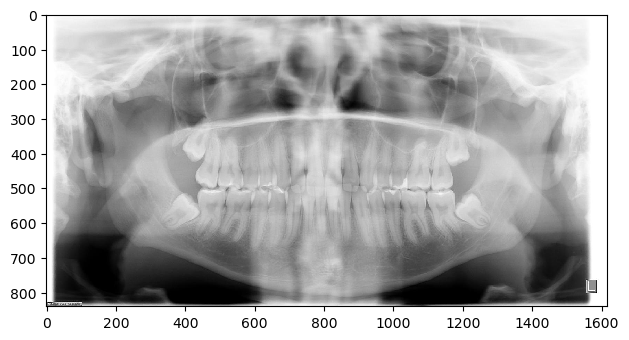

In [12]:
sample_idx = 1
filename = data_folder + "/train/" + annotation_df["filename"][sample_idx]
display(annotation_df.iloc[sample_idx])
sample_img = ski.io.imread(filename)
io.imshow(sample_img)

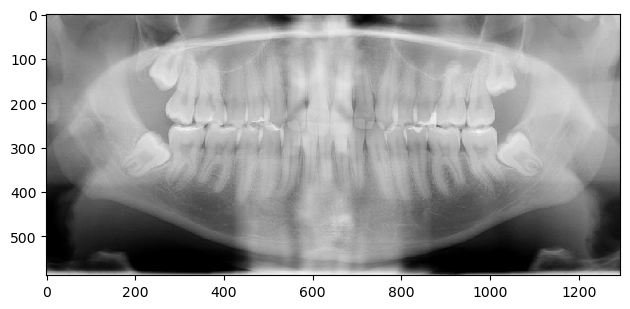

In [13]:
def crop_image(image, height_crop_ratio=0.30, width_crop_ratio=0.10):
    new_edge = int(image.shape[1] * width_crop_ratio)

    cropped_img = image[int(height_crop_ratio * image.shape[0]):, :]
    cropped_img = cropped_img[:, new_edge:-new_edge]
    return cropped_img


def cropped_bbox(image, bbox, height_crop_ratio=0.30, width_crop_ratio=0.10):
    height = image.shape[0]
    width = image.shape[1]
    xmin, ymin, xmax, ymax = bbox

    top_crop = int(height * height_crop_ratio)
    side_crop = int(width * width_crop_ratio)

    ymin -= top_crop
    ymax -= top_crop
    xmin -= side_crop
    xmax -= side_crop
    return xmin, ymin, xmax, ymax


sample_img = crop_image(sample_img)
io.imshow(sample_img)

In [14]:
def delete_folder_content(folder_path):
    files = os.listdir(folder_path)

    # Iterate over each file and delete it
    for file in files:
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

In [15]:
def crop_folder(folder_name, output_folder):
    csv_name = "_annotations.csv"
    df = pd.read_csv(folder_name + csv_name)
    filepaths = list(df["filename"].unique())
    filepaths = [folder_name + filename for filename in filepaths]
    img_collection = io.imread_collection(filepaths)

    delete_folder_content(output_folder)
    for filepath, image in zip(img_collection.files, img_collection):
        filename = filepath.split("/")[-1]
        annotation_rows = df[df["filename"] == filename]
        cropped_img = crop_image(image.copy())
        io.imsave(output_folder + filename, cropped_img)

        # Update Bounding Box
        for index, row in annotation_rows.iterrows():
            df.at[index, 'height'] = cropped_img.shape[0]
            df.at[index, 'width'] = cropped_img.shape[1]
            xmin, ymin, xmax, ymax = cropped_bbox(
                image,
                [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
            )
            df.at[index, 'xmin'] = xmin
            df.at[index, 'ymin'] = ymin
            df.at[index, 'xmax'] = xmax
            df.at[index, 'ymax'] = ymax

    df.to_csv(output_folder + csv_name, index=False, header=True)

In [16]:
crop_folder(splitted + "/train/", "data/cropped_data/train/")
crop_folder(splitted + "/valid/", "data/cropped_data/valid/")
crop_folder(splitted + "/test/", "data/cropped_data/test/")

In [17]:
def check_invalid_bbox(csv_file):
    combined_df = pd.read_csv(csv_file)
    # Assuming combined_df is your DataFrame

    # Find rows where xmin or xmax values are negative or exceed width
    invalid_x_values = combined_df[(combined_df['xmin'] < 0) | (
        combined_df['xmax'] > combined_df['width'])]

    # Find rows where ymin or ymax values are negative or exceed height
    invalid_y_values = combined_df[(combined_df['ymin'] < 0) | (
        combined_df['ymax'] > combined_df['height'])]

    # Find rows where width is negative or invalid (xmax - xmin)
    invalid_widths = combined_df[combined_df['xmax'] -
                                 combined_df['xmin'] <= 0]

    # Find rows where height is negative or invalid (ymax - ymin)
    invalid_heights = combined_df[combined_df['ymax'] -
                                  combined_df['ymin'] <= 0]

    # Check if there are any invalid x values
    if not invalid_x_values.empty:
        print("Invalid x values found:")
        print(invalid_x_values)

    # Check if there are any invalid y values
    if not invalid_y_values.empty:
        print("Invalid y values found:")
        print(invalid_y_values)
        print(len(invalid_y_values))

    # Check if there are any invalid widths
    if not invalid_widths.empty:
        print("Invalid widths found:")
        print(invalid_widths)

    # Check if there are any invalid heights
    if not invalid_heights.empty:
        print("Invalid heights found:")
        print(invalid_heights)


check_invalid_bbox("data/cropped_data/train/_annotations.csv")
check_invalid_bbox("data/cropped_data/test/_annotations.csv")
check_invalid_bbox("data/cropped_data/test/_annotations.csv")

Invalid widths found:
                                            filename  width  height  \
307  393_JPG.rf.bcb7b3f1ea6d9a91f6a4d6babbb6f5a5.jpg   1293     588   

             class  xmin  ymin  xmax  ymax  
307  Mesio-angular  1164   199  1164   200  


# Data Augmentation


## Random Erasing & GridMask


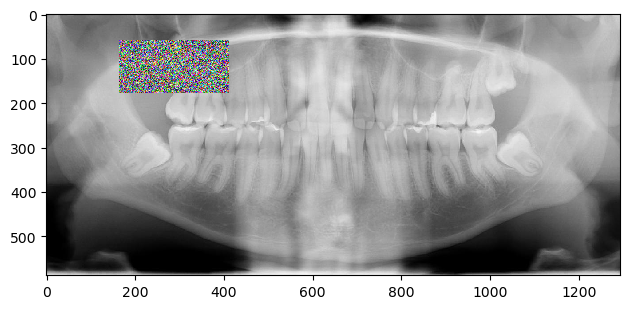

In [18]:
eraser = get_random_eraser(p=1, s_h=0.1, s_l=0.01, r_1=0.3, r_2=2, pixel_level=True)
io.imshow(eraser(sample_img.copy()))

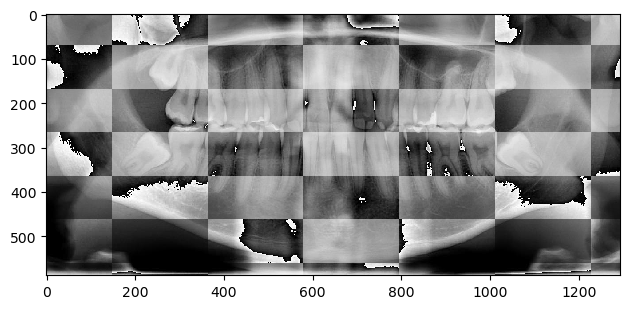

In [19]:
gridmask_transformer = A.Compose([GridMask(num_grid=3, fill_value=2, mode=2, p=1)])

gridmasked_img = gridmask_transformer(image=sample_img.copy())
io.imshow(gridmasked_img.get("image"))

## Getting Images


In [20]:
# Only augment training data
df = pd.read_csv("data/cropped_data/train/_annotations.csv")
# File -> probability of being augmented according to class
file_priority = []
file_priority_mapper = {}
priority_mapper = {
    "Erupted": 0.4,
    "Mesio-angular": 0.5,
    "Vertical": 0.8,
    "Horizontal": 0.7,
    "Disto-angular": 0.8,
}
all_img_files = df["filename"].unique()
np.random.seed(314)

# Check all instances of an object in a file
# convert class of instances to probability (priority_mapper)
# The highest probability is assigned to the file
for file in all_img_files:
    class_instances = df[df["filename"] == file]["class"].unique()
    priorities = [
        priority_mapper.get(class_instance) for class_instance in class_instances
    ]
    file_priority.append([file, max(priorities)])
    file_priority_mapper[file] = max(priorities)

file_priority_df = pd.DataFrame(file_priority, columns=["file_name", "priority_level"])

# Add a column to see which files will be augmented
file_priority_df["for_augmentation"] = np.random.rand(len(file_priority_df))
file_priority_df["for_augmentation"] = file_priority_df.apply(
    lambda row: row["for_augmentation"] <= row["priority_level"], axis=1
)

display(file_priority_df["for_augmentation"].value_counts())

# Get list of file paths of images to be augmented
files_for_augmentation = list(
    file_priority_df[file_priority_df["for_augmentation"]]["file_name"]
)
files_for_augmentation = [
    "data/cropped_data/train/" + name for name in files_for_augmentation
]

for_augmentation
True     110
False    109
Name: count, dtype: int64

In [21]:
# Read all images
img_collection = io.imread_collection(files_for_augmentation)

# Random Eraser
eraser = get_random_eraser(p=1, s_h=0.1, s_l=0.01, r_1=0.3, r_2=2, pixel_level=True)

# GridMasker
gridmasker_6m0 = A.Compose([GridMask(num_grid=2, fill_value=3, mode=0, p=1)])
gridmasker_6m2 = A.Compose([GridMask(num_grid=2, fill_value=3, mode=2, p=1)])
gridmasker_3m0 = A.Compose([GridMask(num_grid=7, fill_value=3, mode=0, p=1)])
gridmasker_3m2 = A.Compose([GridMask(num_grid=3, fill_value=3, mode=2, p=1)])

In [22]:
def get_new_filename(base, counter):
    return "aug" + str(counter) + "_" + base.split(".")[0] + ".jpg"


def generate_augmented_annotation(filename, rows, df):
    annotation_rows = pd.DataFrame(rows, columns=df.columns)
    annotation_rows["filename"] = filename
    return pd.concat([df, annotation_rows], ignore_index=True)

In [ ]:
annotation_output_folder = "data/augmented_data/"
output_folder = annotation_output_folder + "images/"

delete_folder_content(output_folder)
# For each augmented image, bounding box must be preserved
annotation_augmented_df = pd.DataFrame(columns=df.columns)

for filepath, image in zip(img_collection.files, img_collection):
    filename = filepath.split("/")[-1]
    file_annotation_rows = df[df["filename"] == filename]
    counter = 0
    if file_priority_mapper[filename] >= 0.8:
        augmented_res = gridmasker_6m0(image=image.copy())
        augmented_res = augmented_res.get("image")
        augmented_filename = get_new_filename(filename, counter)
        io.imsave(output_folder + augmented_filename, augmented_res)
        annotation_augmented_df = generate_augmented_annotation(
            augmented_filename, file_annotation_rows, annotation_augmented_df)
        counter += 1

        augmented_res = gridmasker_6m2(image=image.copy())
        augmented_res = augmented_res.get("image")
        augmented_filename = get_new_filename(filename, counter)
        io.imsave(output_folder + augmented_filename, augmented_res)
        annotation_augmented_df = generate_augmented_annotation(
            augmented_filename, file_annotation_rows, annotation_augmented_df)
        counter += 1

    if file_priority_mapper[filename] >= 0.5:
        augmented_res = gridmasker_3m2(image=image.copy())
        augmented_res = augmented_res.get("image")
        augmented_filename = get_new_filename(filename, counter)
        io.imsave(output_folder + augmented_filename, augmented_res)
        annotation_augmented_df = generate_augmented_annotation(
            augmented_filename, file_annotation_rows, annotation_augmented_df)
        counter += 1

    if file_priority_mapper[filename] >= 0.2:
        # augmented_res = eraser(image.copy())
        # augmented_filename = get_new_filename(filename, counter)
        # io.imsave(output_folder + augmented_filename, augmented_res)
        # annotation_augmented_df = generate_augmented_annotation(
        #     augmented_filename, file_annotation_rows, annotation_augmented_df)
        # counter += 1

        augmented_res = gridmasker_3m0(image=image.copy())
        augmented_res = augmented_res.get("image")
        augmented_filename = get_new_filename(filename, counter)
        io.imsave(output_folder + augmented_filename, augmented_res)
        annotation_augmented_df = generate_augmented_annotation(
            augmented_filename, file_annotation_rows, annotation_augmented_df)
        counter += 1

annotation_augmented_df.to_csv(
    annotation_output_folder + "_annotations.csv", index=False, header=True)
display(annotation_augmented_df["class"].value_counts())
print(len(annotation_augmented_df["filename"].unique()))
annotation_augmented_df

# Combining Augmented Data and Test Data


In [ ]:
def copy_folder(source_folder, destination_folder):
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
    shutil.copytree(source_folder, destination_folder)
    print(
        f"Folder '{source_folder}' copied to '{destination_folder}' successfully.")


def copy_folder_contents(source_folder, destination_folder):
    # Iterate over each file in the source folder
    for file_name in os.listdir(source_folder):
        source_file_path = os.path.join(source_folder, file_name)
        destination_file_path = os.path.join(destination_folder, file_name)

        # Check if the file already exists in the destination folder
        if not os.path.exists(destination_file_path):
            # Copy the file to the destination folder
            shutil.copy2(source_file_path, destination_folder)
        else:
            print(
                f"File '{file_name}' already exists in '{destination_folder}'. Skipping.")

In [ ]:
# # UNCOMMENT IF
# # You want the cropped_data + augmented data all in one folder
# combined_folder = "data/cropped_augmented_data/"
# augmented_folder = "data/augmented_data/"
# copy_folder("data/cropped_data", "data/cropped_augmented_data")

# combined_df_path = combined_folder + "train/_annotations.csv"
# combined_df = pd.read_csv(combined_df_path)
# augmented_df = pd.read_csv(augmented_folder + "_annotations.csv")
# combined_df = pd.concat([combined_df, augmented_df], ignore_index=True)
# copy_folder_contents(augmented_folder + "images/", combined_folder + "train/")
# combined_df.to_csv(combined_df_path)

# Preprocessing


In [24]:
def to_gray(image):
    if len(image.shape) == 3:
        return color.rgb2gray(image)
    else:
        return image

Obtaining a sample image


filename           263_JPG.rf.f25196852011c14a937aea7f5efe97ad.jpg
width                                                         1615
height                                                         840
class                                                Mesio-angular
xmin                                                          1177
ymin                                                           514
xmax                                                          1297
ymax                                                           634
ymin_percentage                                          61.190476
ymax_percentage                                           24.52381
xmin_percentage                                          72.879257
xmax_percentage                                          19.690402
Name: 1, dtype: object

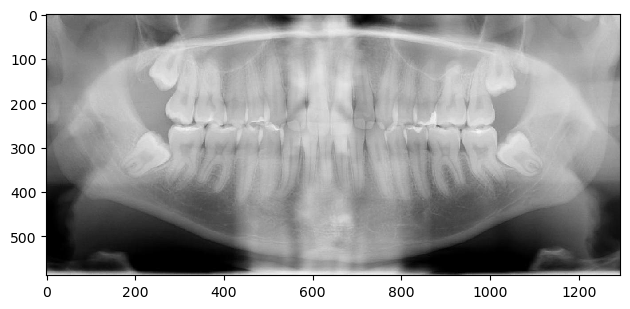

In [25]:

filename = "data/cropped_data/train/" + \
    annotation_train_df["filename"][sample_idx]
display(annotation_train_df.iloc[sample_idx])
sample_img = ski.io.imread(filename)
sample_img = to_gray(sample_img)
io.imshow(sample_img)

In [42]:
def compare_img(images, titles=[], save_to="", dpi=600):
    num_images = len(images)
    # make default image titles (Image 1, Image 2...)
    if len(titles) != num_images:
        titles = [("Image " + str(i)) for i in range(1, num_images + 1)]
    plt.figure(figsize=(15, 2 * num_images))

    # Plot each image vertically stacked
    for i, image in enumerate(images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(titles[i])
        plt.axis("off")

    # Plot images stacked vertically
    plt.tight_layout()
    if len(save_to):
        plt.savefig(save_to, dpi=dpi)
    plt.show()

## Image Enhancements


In [27]:
def guassian_high_pass_filter(image):
    if len(image.shape) == 3:
        image_gray = color.rgb2gray(image)
    else:
        image_gray = image

    # Bandpass-filter
    filtered_image = difference_of_gaussians(image, 2, 12)
    return filtered_image


def contrast_stertching(image):
    # Contrast stretching
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

    # Histogram equalization
    img_eq = exposure.equalize_hist(img_rescale)

    # Adaptive histogram equalization
    img_adapteq = exposure.equalize_adapthist(img_eq, clip_limit=0.03)
    return img_adapteq


def binarization(image):
    threshold_value = filters.threshold_otsu(image)
    binary_image = image > threshold_value
    return binary_image


def morphological_operations(image, disk_size=3):
    footprint = disk(disk_size)
    median_filtered_img = filters.median(image, footprint)
    eroded_img = erosion(median_filtered_img, footprint)
    output_img = opening(eroded_img, footprint)
    return output_img

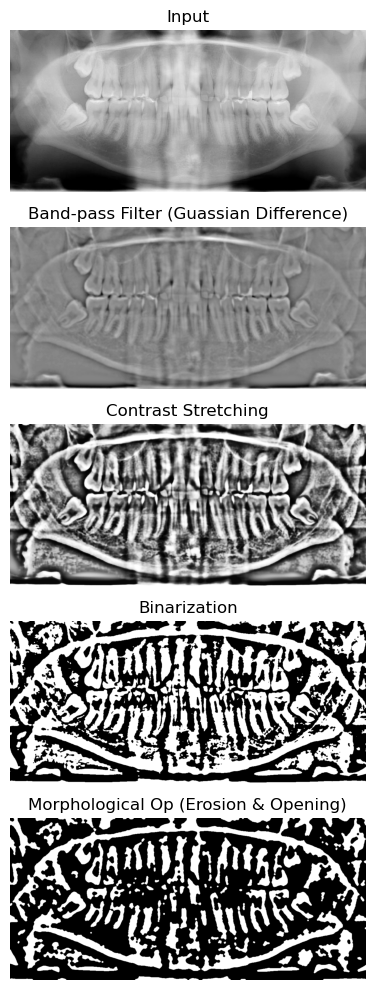

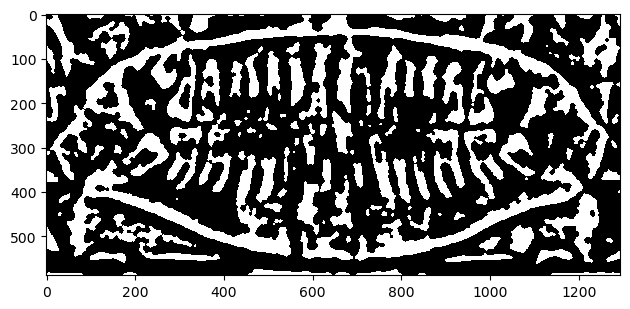

In [28]:
def image_enhancement(img, show_results=True, stages_path="", return_stages=False):
    stages = []
    titles = []

    image = to_gray(img)
    stages.append(image)
    titles.append("Input")

    titles.append("Band-pass Filter (Guassian Difference)")
    stages.append(guassian_high_pass_filter(stages[-1]))

    titles.append("Contrast Stretching")
    stages.append(contrast_stertching(stages[-1]))

    titles.append("Binarization")
    stages.append(binarization(stages[-1]))

    titles.append("Morphological Op (Erosion & Opening)")
    stages.append(morphological_operations(stages[-1]))
    if show_results:
        compare_img(stages, titles, stages_path)
        io.imshow(stages[-1])

    if return_stages:
        return stages
    return stages[-1]


# test function
enhanced_img = image_enhancement(sample_img)

In [29]:
def test_augmented_enhancement(idx):
    filename = "data/augmented_data/images/" + \
        annotation_augmented_df["filename"][idx]
    sample_img = ski.io.imread(filename)
    image_enhancement(sample_img)

## Enhancing Datasets


In [30]:
def enhance_image_folder(folder_path):
    images = io.imread_collection(folder_path)
    print(len(images))
    for idx, image in enumerate(images):
        enhanced_img = image_enhancement(image, False)
        enhanced_img = ski.img_as_ubyte(enhanced_img)
        file_path = images.files[idx]
        io.imsave(file_path, enhanced_img)

In [ ]:
copy_folder("data/cropped_data/", "data/enhanced_cropped_data/")
enhance_image_folder("data/enhanced_cropped_data/train/*.jpg")

In [ ]:
enhance_image_folder("data/enhanced_cropped_data/test/*.jpg")

46


In [ ]:
enhance_image_folder("data/enhanced_cropped_data/valid/*.jpg")

46


In [ ]:
copy_folder("data/augmented_data/images", "data/enhanced_augmented_data")
shutil.copy("data/augmented_data/_annotations.csv",
            "data/enhanced_augmented_data")
enhance_image_folder("data/enhanced_augmented_data/*.jpg")

Folder 'data/augmented_data/images' copied to 'data/enhanced_augmented_data' successfully.
224


# Generating Images for Paper


filename           573_JPG.rf.faf6d6531c294df207f2b80edf05642e.jpg
width                                                         1615
height                                                         840
class                                                      Erupted
xmin                                                          1152
ymin                                                           342
xmax                                                          1260
ymax                                                           495
ymin_percentage                                          40.714286
ymax_percentage                                          41.071429
xmin_percentage                                          71.331269
xmax_percentage                                          21.981424
Name: 13, dtype: object

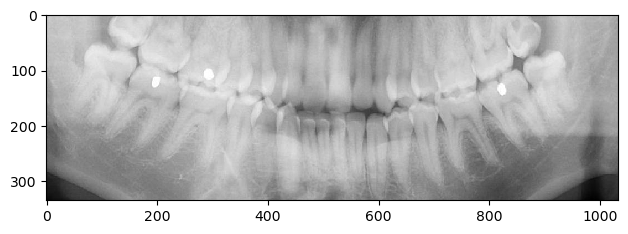

In [40]:
sample_idx = 13
filename = "data/cropped_data/train/" + \
    annotation_train_df["filename"][sample_idx]
display(annotation_train_df.iloc[sample_idx])

sample_img = ski.io.imread(filename)
top_height = int(sample_img.shape[0] * 0.05)
bottom_height = int(sample_img.shape[0] * 0.62)
left_side = int(sample_img.shape[1] * 0.1)
right_side = int(sample_img.shape[1] * 0.9)
sample_img = sample_img[top_height:bottom_height, left_side:right_side]
sample_img = to_gray(sample_img)
io.imshow(sample_img)

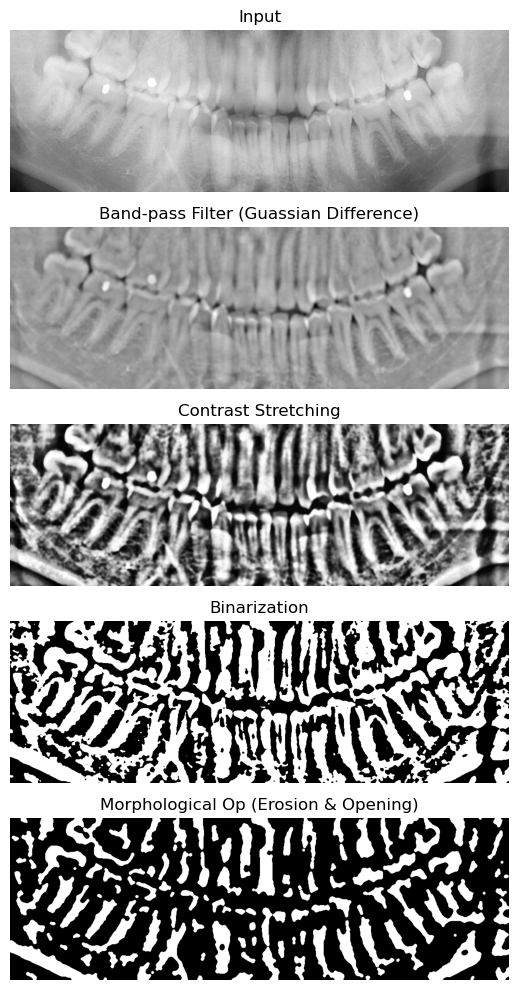

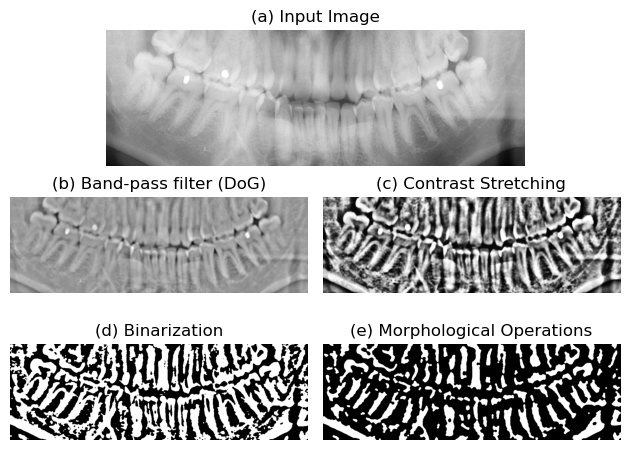

In [56]:
# Image Enhancement
enhanced_imgs = image_enhancement(sample_img, return_stages=True)
stage_names = ["(a) Input Image", "(b) Band-pass filter (DoG)",
               "(c) Contrast Stretching", "(d) Binarization", "(e) Morphological Operations"]
plt.clf()
plots = [
    plt.subplot2grid((3, 2), (0, 0), colspan=2),
    plt.subplot2grid((3, 2), (1, 0)),
    plt.subplot2grid((3, 2), (1, 1)),
    plt.subplot2grid((3, 2), (2, 0)),
    plt.subplot2grid((3, 2), (2, 1)),
]

for i, img in enumerate(enhanced_imgs):
    plot = plots[i]
    plot.imshow(img, cmap="grey")
    plot.set_title(stage_names[i])
    plot.axis("off")
    


plt.tight_layout()
plt.savefig("data/paper_imgs/enhancement_stages.png", dpi=600)

# Input Sizing (Archived)


In [ ]:
def pad_to_square(image):
    # Ensuring it is grayscale
    if len(image.shape) == 3:
        img = color.rgb2gray(image)
    else:
        img = image
    # original height and width
    # assumption: width > height
    height, width = img.shape
    even_diff = ((width - height) % 2) == 0
    y_offset = int((width - height) / 2)
    offset_img = np.ones((y_offset, width))
    odd_offset_img = np.ones((1, width))
    # Ensuring it is grayscale
    if even_diff:
        output_img = np.vstack((offset_img, img, offset_img))
    else:
        output_img = np.vstack((offset_img, img, odd_offset_img, offset_img))
    print("final dimension:", output_img.shape)
    io.imshow(output_img, cmap="gray")
    return output_img


padded_img = pad_to_square(cropped_img)

In [ ]:
def resize_to_input(image, size=640):
    # Assumes input is square
    # original height and width
    height, width = image.shape

    scale = size / width
    resized_img = resize(image, (size, size))
    io.imshow(resized_img)
    return resized_img


enhanced_padded_img = image_enhancement(cropped_img)
padded_enhanced_img = pad_to_square(enhanced_img)
resized_padded_enhanced_img = resize_to_input(padded_enhanced_img)